# Preparation of a benchmark
This notebook can be used to prepare the calculations to be ran for the benchmark.
We first need to define a _campaign_, which is nothing but a list of runs which will be then
converted into the benchmak pool.

## Remote Infrastructure
This routine generates an input file with the parameters we want to test.
We here define the input file of a linar scaling calculation of `2CzPN` molecules

In [1]:
import yaml
new = """
import: linear
perf:
  check_sumrho: 0
  check_overlap: 0
lin_general:
  charge_multipoles: 0
  output_mat: 0"""
lin_dict = yaml.safe_load(new)

In [2]:
def input_template(linear=False):
    import BigDFT.Inputfiles as I
    # Basic Input Parameters 
    inp = I.Inputfile()
    inp.set_xc("PBE")
    inp.set_hgrid(0.5)
    inp.set_rmult(coarse=5.0, fine=7.0) 
    # Get the PSP directory
    inp.set_psp_nlcc()   
    if linear:
        inp.update(lin_dict)
    return inp

In [4]:
computer = "irene_gnu"
systems = "2CzPN"
linear = False
# lincub='linear' if linear else 'cubic'
# rundirs={'irene_gnu': ('/ccc/work/cont003/gen12049/genovesl/2023_remote_bench_gnu/2Cz_PN-start/' + lincub,
#                    'local_work_irene_2023_gnu_' + lincub),
#          'irene_intel': ('/ccc/work/cont003/gen12049/genovesl/2023_remote_bench_intel/2Cz_PN-start/' + lincub,
#                    'local_work_irene_2023_intel_' + lincub),
#          'hokusai': ('/home/wddawson/runs/2022/remote_benchmark',
#                      'local_work_hokusai'),
#          'archer2': ('/work/e572/e572/shared/bench/cubic_test/run_2CzPN',
#                      '/work/e572/e572/shared/bench/cubic_test/run_2CzPN'),
#          'vega': ('/ceph/hpc/home/eugenovesel/remote_bench/intel/2Cz_PN/' + lincub,
#                   'local_work_vega_intel/' + lincub)}
# remote_dir, local_dir = rundirs[computer]

This is the full remote routine we want to run to handle a given structure.

## Remote Calculation
First we use the data to setup our remote specs.

In [3]:
import benchmark

In [4]:
def dry_run_bench(filelist, **kwargs):
    from os.path import basename
    newspec={}
    for f in filelist:
        #size = str(run['mpi'])+'-'+str(run['omp'])
        posinp = basename(f)
        name = posinp + '-dry'
        spec={}
        spec.update(**kwargs)
        spec.update({'dry_run': True, 'name': name, 'posinp': posinp})
        newspec[f]=[spec]
    return newspec

In [5]:
current_bench={'directory': 'input',
              'prefix': '2CzPN',
              'suffix': '.pdb'}           

In [6]:
from futile.Utils import file_list
from os.path import basename, splitext
pre_bench={f:[{'name':splitext(basename(f))[0]}] 
           for f in file_list(include_directory_path=True,
                              **current_bench)}

This is the first example of a benchmark set. Let's inspect the `pre_bench` dictionary:

In [7]:
pre_bench

{'input/2CzPN_10.pdb': [{'name': '2CzPN_10'}],
 'input/2CzPN_82.pdb': [{'name': '2CzPN_82'}],
 'input/2CzPN_122.pdb': [{'name': '2CzPN_122'}],
 'input/2CzPN_442.pdb': [{'name': '2CzPN_442'}],
 'input/2CzPN_602.pdb': [{'name': '2CzPN_602'}],
 'input/2CzPN_234.pdb': [{'name': '2CzPN_234'}],
 'input/2CzPN_730.pdb': [{'name': '2CzPN_730'}],
 'input/2CzPN_250.pdb': [{'name': '2CzPN_250'}],
 'input/2CzPN_114.pdb': [{'name': '2CzPN_114'}],
 'input/2CzPN_42.pdb': [{'name': '2CzPN_42'}],
 'input/2CzPN_98.pdb': [{'name': '2CzPN_98'}],
 'input/2CzPN_26.pdb': [{'name': '2CzPN_26'}],
 'input/2CzPN_474.pdb': [{'name': '2CzPN_474'}],
 'input/2CzPN_170.pdb': [{'name': '2CzPN_170'}],
 'input/2CzPN_50.pdb': [{'name': '2CzPN_50'}],
 'input/2CzPN_30.pdb': [{'name': '2CzPN_30'}],
 'input/2CzPN_18.pdb': [{'name': '2CzPN_18'}],
 'input/2CzPN_2.pdb': [{'name': '2CzPN_2'}],
 'input/2CzPN_16.pdb': [{'name': '2CzPN_16'}],
 'input/2CzPN_410.pdb': [{'name': '2CzPN_410'}],
 'input/2CzPN_570.pdb': [{'name': '2CzPN_5

it essentially contains the name of the input file and the nome of the corresponding job.
Information about the number of MPI and OMP process should be inserted..

In [8]:
!rm dataset-dry-bench-4ee42d55.yaml

In [9]:
from remotemanager import Dataset
ds=Dataset(benchmark.run_bigdft,local_dir='dry-bench',database_file='dry.yaml',remote_dir='dry-bench',name='dry-bench')
for run in benchmark.campaign(pre_bench, dry_run=True, input=input_template()):
    #print(run)
    ds.append_run(lazy=True,**run)

In [10]:
ds.finish_append()

Of 53 appends: 53 appended
See append_log for more info


In [11]:
ds.run()

Running Dataset
Transferring 161 Files in 2 Transfers... Done
Of 53 runners, 53 run, see run_log for more info


In [12]:
ds.fetch_results()

Fetching results
Transferring 34 Files... Done


These calculations test the number of orbitals of each of the runs in the input file and prepare the data for the strong scaling benchmark creation

# Extraction of the results
This section creates the spec of a benchmark from the initial runs of a system.

In [14]:
import benchmark

In [15]:
from futile.Utils import file_list
df=benchmark.dataframe(benchmark.extract_results('dry-bench'))

In [32]:
dft=df.sort_values('Nat')
dft

name timefile WFN_OPT   Hostname  \
dry-bench/log-2CzPN_1.yaml        2CzPN_1     None    None  localhost   
dry-bench/log-2CzPN_2.yaml        2CzPN_2     None    None  localhost   
dry-bench/log-2CzPN_4.yaml        2CzPN_4     None    None  localhost   
dry-bench/log-2CzPN_6.yaml        2CzPN_6     None    None  localhost   
dry-bench/log-2CzPN_8.yaml        2CzPN_8     None    None  localhost   
dry-bench/log-2CzPN_10.yaml      2CzPN_10     None    None  localhost   
dry-bench/log-2CzPN_12.yaml      2CzPN_12     None    None  localhost   
dry-bench/log-2CzPN_14.yaml      2CzPN_14     None    None  localhost   
dry-bench/log-2CzPN_16.yaml      2CzPN_16     None    None  localhost   
dry-bench/log-2CzPN_18.yaml      2CzPN_18     None    None  localhost   
dry-bench/log-2CzPN_22.yaml      2CzPN_22     None    None  localhost   
dry-bench/log-2CzPN_26.yaml      2CzPN_26     None    None  localhost   
dry-bench/log-2CzPN_30.yaml      2CzPN_30     None    None  localhost   
dry-bench/log-2CzPN_34.yaml      2CzPN_34     None    None  localhost   
dry-bench/log-2CzPN_38.yaml      2CzPN_38     None    None  localhost   
dry-bench/log-2CzPN_42.yaml      2CzPN_42     None    None  localhost   
dry-bench/log-2CzPN_50.yaml      2CzPN_50     None    None  localhost   
dry-bench/log-2CzPN_58.yaml      2CzPN_58     None    None  localhost   
dry-bench/log-2CzPN_66.yaml      2CzPN_66     None    None  localhost   
dry-bench/log-2CzPN_74.yaml      2CzPN_74     None    None  localhost   
dry-bench/log-2CzPN_82.yaml      2CzPN_82     None    None  localhost   
dry-bench/log-2CzPN_90.yaml      2CzPN_90     None    None  localhost   
dry-bench/log-2CzPN_98.yaml      2CzPN_98     None    None  localhost   
dry-bench/log-2CzPN_106.yaml    2CzPN_106     None    None  localhost   
dry-bench/log-2CzPN_114.yaml    2CzPN_114     None    None  localhost   
dry-bench/log-2CzPN_122.yaml    2CzPN_122     None    None  localhost   
dry-bench/log-2CzPN_138.yaml    2CzPN_138     None    None  localhost   
dry-bench/log-2CzPN_154.yaml    2CzPN_154     None    None  localhost   
dry-bench/log-2CzPN_170.yaml    2CzPN_170     None    None  localhost   
dry-bench/log-2CzPN_186.yaml    2CzPN_186     None    None  localhost   
dry-bench/log-2CzPN_202.yaml    2CzPN_202     None    None  localhost   
dry-bench/log-2CzPN_218.yaml    2CzPN_218     None    None  localhost   
dry-bench/log-2CzPN_234.yaml    2CzPN_234     None    None  localhost   
dry-bench/log-2CzPN_250.yaml    2CzPN_250     None    None  localhost   
dry-bench/log-2CzPN_266.yaml    2CzPN_266     None    None  localhost   
dry-bench/log-2CzPN_282.yaml    2CzPN_282     None    None  localhost   
dry-bench/log-2CzPN_314.yaml    2CzPN_314     None    None  localhost   
dry-bench/log-2CzPN_346.yaml    2CzPN_346     None    None  localhost   
dry-bench/log-2CzPN_378.yaml    2CzPN_378     None    None  localhost   
dry-bench/log-2CzPN_410.yaml    2CzPN_410     None    None  localhost   
dry-bench/log-2CzPN_442.yaml    2CzPN_442     None    None  localhost   
dry-bench/log-2CzPN_474.yaml    2CzPN_474     None    None  localhost   
dry-bench/log-2CzPN_506.yaml    2CzPN_506     None    None  localhost   
dry-bench/log-2CzPN_538.yaml    2CzPN_538     None    None  localhost   
dry-bench/log-2CzPN_570.yaml    2CzPN_570     None    None  localhost   
dry-bench/log-2CzPN_602.yaml    2CzPN_602     None    None  localhost   
dry-bench/log-2CzPN_666.yaml    2CzPN_666     None    None  localhost   
dry-bench/log-2CzPN_730.yaml    2CzPN_730     None    None  localhost   
dry-bench/log-2CzPN_794.yaml    2CzPN_794     None    None  localhost   
dry-bench/log-2CzPN_858.yaml    2CzPN_858     None    None  localhost   
dry-bench/log-2CzPN_922.yaml    2CzPN_922     None    None  localhost   
dry-bench/log-2CzPN_986.yaml    2CzPN_986     None    None  localhost   
dry-bench/log-2CzPN_1000.yaml  2CzPN_1000     None    None  localhost   

                                                     Date MPI OMP       Mem  \
dry-bench/log-2

With the above cell we have extracte the results of the directory `dry-bench`.
We will now use these results to create the actual list of runs we will execute remotely on the platforms.

In [18]:
def create_strong_scaling(functions,starting_from,ending_to,max_tasks=None):
    minnodes = int((functions -1 ) / starting_from) + 1
    maxnodes = int((functions - 1)/ ending_to) + 1
    if max_tasks is not None:
        maxnodes = min(maxnodes, max_tasks)
    runs = []
    nodes=minnodes
    while nodes <= maxnodes:
        runs.append(nodes)
        nodes *= 2
    return runs

In [35]:

#the value below is related to the number of atoms of the 2CzPN molecule
fragment_size=83 
def create_bench_spec(dft,cores_per_node,omps,max_nodes,fragment_size):
    from os.path import basename, splitext
    bench_spec = {}
    for file,val in zip(dft['name'],dft['Orbitals']):
        #print(file)
        nmol=val/fragment_size
        runs=[]
        # at least one fragment
        minval = max(cores_per_node*4, fragment_size)
        for omp in omps:
            mpi_per_node=int((cores_per_node/omp))
            #print(mpi_per_node,omp)
            for nodes in create_strong_scaling(val,minval,cores_per_node,max_tasks=max_nodes):
                mpi= nodes * mpi_per_node
                if (omp*mpi)%cores_per_node ==0 or omp*mpi < cores_per_node:
                    size = str(mpi)+'-'+str(omp)
                    name = file + '-' + size
                    runs.append({'omp':omp, 'mpi':mpi, 'name': name})
        bench_spec[file+current_bench['suffix']] = runs
    return bench_spec

We can then create the banchmarks for different platforms

In [36]:
bs_summer=create_bench_spec(dft,16,[1,2,4,8],16,fragment_size)

In [37]:
bs_leonardo=create_bench_spec(dft,32,[1,2,4,8,16],4,fragment_size)

The line below creates the list of benchmarks to be performed on the local machine (which in our case has 8 cores per node)

In [38]:
bs_lh=create_bench_spec(dft,8,[1,2,4,8],1,fragment_size)

Note that this is a calculation with cubic scaling activated (defaut arguments of input_template).

In [39]:
from os.path import join
lh_bench=benchmark.campaign({join('input',k): v for k,v in bs_lh.items()},input=input_template())

In [40]:
bs_lh

{'2CzPN_1.pdb': [{'omp': 1, 'mpi': 8, 'name': '2CzPN_1-8-1'},
  {'omp': 2, 'mpi': 4, 'name': '2CzPN_1-4-2'},
  {'omp': 4, 'mpi': 2, 'name': '2CzPN_1-2-4'},
  {'omp': 8, 'mpi': 1, 'name': '2CzPN_1-1-8'}],
 '2CzPN_2.pdb': [],
 '2CzPN_4.pdb': [],
 '2CzPN_6.pdb': [],
 '2CzPN_8.pdb': [],
 '2CzPN_10.pdb': [],
 '2CzPN_12.pdb': [],
 '2CzPN_14.pdb': [],
 '2CzPN_16.pdb': [],
 '2CzPN_18.pdb': [],
 '2CzPN_22.pdb': [],
 '2CzPN_26.pdb': [],
 '2CzPN_30.pdb': [],
 '2CzPN_34.pdb': [],
 '2CzPN_38.pdb': [],
 '2CzPN_42.pdb': [],
 '2CzPN_50.pdb': [],
 '2CzPN_58.pdb': [],
 '2CzPN_66.pdb': [],
 '2CzPN_74.pdb': [],
 '2CzPN_82.pdb': [],
 '2CzPN_90.pdb': [],
 '2CzPN_98.pdb': [],
 '2CzPN_106.pdb': [],
 '2CzPN_114.pdb': [],
 '2CzPN_122.pdb': [],
 '2CzPN_138.pdb': [],
 '2CzPN_154.pdb': [],
 '2CzPN_170.pdb': [],
 '2CzPN_186.pdb': [],
 '2CzPN_202.pdb': [],
 '2CzPN_218.pdb': [],
 '2CzPN_234.pdb': [],
 '2CzPN_250.pdb': [],
 '2CzPN_266.pdb': [],
 '2CzPN_282.pdb': [],
 '2CzPN_314.pdb': [],
 '2CzPN_346.pdb': [],
 '2CzPN_

In [41]:
lh_bench?

Type:        list
String form: [{'extra_files_send': ['input/2CzPN_1.pdb'], 'extra_files_recv': ['2CzPN_1-8-1.tar.gz'], 'jobname <...> .49587651444}, 'Source': 'generated by Saha,2015'}}}, 'omp': 8, 'mpi': 1, 'name': '2CzPN_1-1-8'}]
Length:      4
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.

this is a list of runs that will have to be passed to the remotemanager append_run command as it have been performed above.

# Running the bench

Lets'perform the example about how to run the benchs with the local machine.

In [99]:
from BigDFT.Interop import RemoteManagerInterop as RM
cp=RM.code_compiler('/opt/bigdft/')
cp.append_run(action='buildone -f pybigdft')
cp.run()

appended run runner-0
Running Dataset
assessing run for runner compile-c48c306e-runner-0... running
Transferring 2 Files... Done


In [105]:
from importlib import reload
reload(RM)

<module 'BigDFT.Interop.RemoteManagerInterop' from '/opt/bigdft/install/lib/python3.9/site-packages/BigDFT/Interop/RemoteManagerInterop.py'>

In [106]:
import yaml
templates=yaml.load(RM.computers_database,Loader=yaml.Loader)

In [108]:
from remotemanager import BaseComputer
localhost=BaseComputer(**templates['localhost'])

In [109]:
from remotemanager import Dataset
ds=Dataset(benchmark.run_bigdft,local_dir='local_work_leonardo',
           dbfile='localhost.yaml',
           remote_dir='small_test',
           name='2CzPN',url=localhost,asynchronous=False,skip=False)
for run in lh_bench:
    #print(run)
    ds.append_run(lazy=True,**run)
ds.finish_append()

Of 4 appends: 4 appended
See append_log for more info


In [110]:
ds.run()

Running Dataset
assessing run for runner 2CzPN-0e829193-2CzPN_1-8-1... running
assessing run for runner 2CzPN-0e829193-2CzPN_1-4-2... running
assessing run for runner 2CzPN-0e829193-2CzPN_1-2-4... running
assessing run for runner 2CzPN-0e829193-2CzPN_1-1-8... running
Transferring 11 Files in 2 Transfers... Done


In [111]:
ds.fetch_results()

Fetching results
Transferring 7 Files... Done


In [117]:
df_lh=benchmark.dataframe(benchmark.extract_results(directory='small_test')).sort_values('OMP')
df_lh

name  \
small_test/log-2CzPN_1-8-1.yaml  2CzPN_1-8-1   
small_test/log-2CzPN_1-4-2.yaml  2CzPN_1-4-2   
small_test/log-2CzPN_1-2-4.yaml  2CzPN_1-2-4   
small_test/log-2CzPN_1-1-8.yaml  2CzPN_1-1-8   

                                                           timefile WFN_OPT  \
small_test/log-2CzPN_1-8-1.yaml  small_test/./time-2CzPN_1-8-1.yaml   486.0   
small_test/log-2CzPN_1-4-2.yaml  small_test/./time-2CzPN_1-4-2.yaml   123.0   
small_test/log-2CzPN_1-2-4.yaml  small_test/./time-2CzPN_1-2-4.yaml   129.0   
small_test/log-2CzPN_1-1-8.yaml  small_test/./time-2CzPN_1-1-8.yaml   132.0   

                                     energy             Hostname  \
small_test/log-2CzPN_1-8-1.yaml -263.035528  bigdft/sdk:oneapi24   
small_test/log-2CzPN_1-4-2.yaml -263.035528  bigdft/sdk:oneapi24   
small_test/log-2CzPN_1-2-4.yaml -263.035528  bigdft/sdk:oneapi24   
small_test/log-2CzPN_1-1-8.yaml -263.035528  bigdft/sdk:oneapi24   

                                                       Date MPI OMP       Mem  \
small_test/log-2CzPN_1-8-1.yaml  2024-10-23 17:59:23.247000   1   1  3227.712   
small_test/log-2CzPN_1-4-2.yaml  2024-10-23 19:27:18.734000   4   2  1007.208   
small_test/log-2CzPN_1-2-4.yaml  2024-10-23 19:29:38.617000   2   4  1846.504   
small_test/log-2CzPN_1-1-8.yaml  2024-10-23 19:32:06.917000   1   8  3252.536   

                                   Walltime   SF Orbitals Electrons Nat cores  \
small_test/log-2CzPN_1-8-1.yaml  543.956813  NaN       83       166  54     1   
small_test/log-2CzPN_1-4-2.yaml   139.15554  NaN       83       166  54     8   
small_test/log-2CzPN_1-2-4.yaml  147.592295  NaN       83       166  54     8   
small_test/log-2CzPN_1-1-8.yaml  152.184103  NaN       83       166  54     8   

                                   TotMem   NodeMem  CPUhours CPUmin/at  \
small_test/log-2CzPN_1-8-1.yaml  3227.712  3227.712  0.151099  0.167888   
small_test/log-2CzPN_1-4-2.yaml  4028.832  1007.208  0.309235  0.343594   
small_test/log-2CzPN_1-2-4.yaml  3693.008  1846.504  0.327983  0.364425   
small_test/log-2CzPN_1-1-8.yaml  3252.536  3252.536  0.338187  0.375763   

                                 Memory/at  
small_test/log-2CzPN_1-8-1.yaml  59.772444  
small_test/log-2CzPN_1-4-2.yaml     74.608  
small_test/log-2CzPN_1-2-4.yaml  68.389037  
small_test/log-2CzPN_1-1-8.yaml  60.232148

This is the result of the benchmark that can be analyzed at will:

<Axes: xlabel='MPI', ylabel='WFN_OPT'>

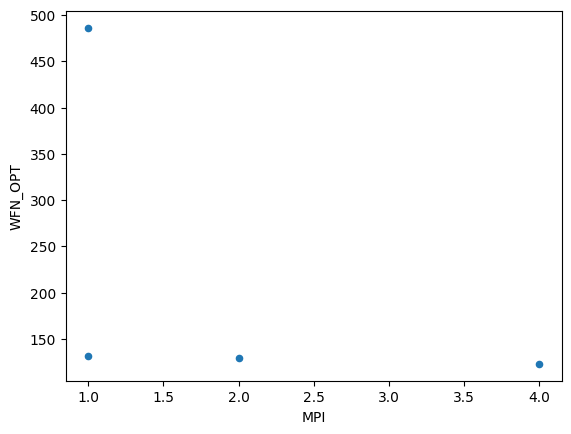

In [118]:
df_lh.plot.scatter('MPI','WFN_OPT')

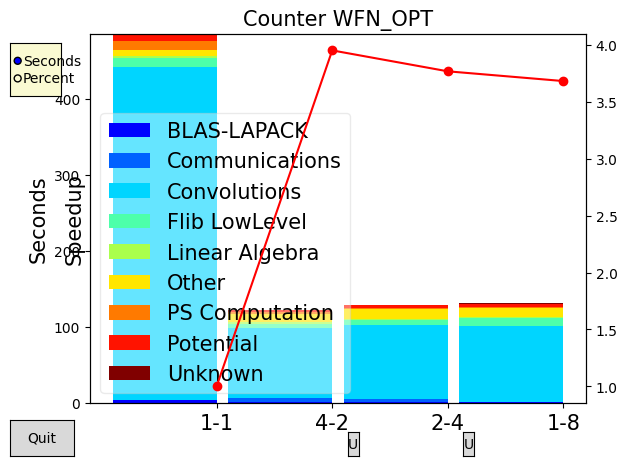

In [119]:
from futile import Time as T
tt=T.TimeData(*df_lh.timefile,only_last=True)

# Examples of other benchmark creation
With this exemple, every bench can be run from this notebook by simply providing the instantation of the remote computer in the `url` argument of the dataset.
Data can be retrieved and analyzed in the form of a dataframe.

In [12]:
archer2_bench=benchmark.campaign({join('input',k): v for k,v in bs.items()},input=input_template(linear=True))

In [177]:
leonardo_bench=benchmark.campaign({join('input',k): v for k,v in bs_summer.items()},input=input_template())

In [171]:
summer_bench=benchmark.campaign({join('input',k): v for k,v in bs_summer.items()},input=input_template())

In [49]:
from os.path import join
irene_bench=benchmark.campaign({join('input',k): v for k,v in bs.items()},input=input_template())

In [178]:
from json import dump
with open('leonardo_bench.json','w') as ofile:
    dump(leonardo_bench, ofile)

In [173]:
with open('summer_bench.json','w') as ofile:
    dump(summer_bench, ofile)

In [172]:
len(summer_bench)

68

Example of the same benchmark on the machine `irene`

In [ ]:
irene=BaseComputer(host='irene', passfile='/tmp/irene',**templates['irene'])

In [113]:
from remotemanager import Dataset
ds=Dataset(benchmark.run_bigdft,local_dir='local_work_irene',
           dbfile='irene.yaml',
           remote_dir='/ccc/work/cont003/drf/genovesl/small_test',
           name='2CzPN',url=irene, time='00:10:00',skip=False)
for run in irene_bench:
    #print(run)
    ds.append_run(lazy=True,**run)
ds.finish_append()

Of 4 appends: 4 added. See run_log for more info


In [114]:
ds.run()

assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-8-1... running
assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-4-2... running
assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-2-4... running
assessing run for runner 2CzPN-0e829193-2CzPN_1.pdb-1-8... running


In [9]:
#newspec

In [10]:
bench_spec = {'input/2CzPN_1.pdb': [{'mpi': 32, 'omp': 4},
  {'mpi': 64, 'omp': 4},
  {'mpi': 96, 'omp': 4},
  {'mpi': 128, 'omp': 4}],
 'input/2CzPN_2.pdb': [{'mpi': 32, 'omp': 4},
  {'mpi': 64, 'omp': 4},
  {'mpi': 96, 'omp': 4},
  {'mpi': 128, 'omp': 4},
  {'mpi': 160, 'omp': 4}],
 'input/2CzPN_4.pdb': [{'mpi': 32, 'omp': 4},
  {'mpi': 64, 'omp': 4},
  {'mpi': 96, 'omp': 4},
  {'mpi': 128, 'omp': 4},
  {'mpi': 160, 'omp': 4}],
 'input/2CzPN_6.pdb': [{'mpi': 32, 'omp': 4},
  {'mpi': 64, 'omp': 4},
  {'mpi': 96, 'omp': 4},
  {'mpi': 128, 'omp': 4},
  {'mpi': 160, 'omp': 4}],
 'input/2CzPN_8.pdb': [{'mpi': 32, 'omp': 4},
  {'mpi': 64, 'omp': 4},
  {'mpi': 96, 'omp': 4},
  {'mpi': 128, 'omp': 4},
  {'mpi': 160, 'omp': 4},
  {'mpi': 192, 'omp': 4}],
 'input/2CzPN_10.pdb': [{'mpi': 32, 'omp': 4},
  {'mpi': 64, 'omp': 4},
  {'mpi': 96, 'omp': 4},
  {'mpi': 128, 'omp': 4},
  {'mpi': 160, 'omp': 4},
  {'mpi': 192, 'omp': 4}]}